In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda
from keras.models import Model
from keras.metrics import binary_crossentropy
import keras.backend as K
from keras.datasets import mnist

from scipy.stats import norm
from sklearn.manifold import Isomap

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from src.utils import process_mnist,gen_trajectory,gen_sorted_isomap
from src.models import build_dense,CachedModel

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
(x_orig,_),(_,_) = mnist.load_data()
x_orig.shape

(60000, 28, 28)

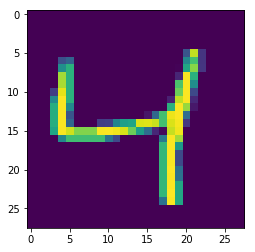

In [5]:
plt.imshow(x_train[2].reshape(28,28))

In [6]:
encoding_dim = 32
latent_dim = 2
inputs = Input(shape=input_shape)
encoded = build_dense(inputs,[256,encoding_dim],activations='relu')

In [7]:
z_mean = Dense(latent_dim)(encoded)
z_log_sigma = Dense(latent_dim)(encoded)

def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

lat_vec = Lambda(sampler)([z_mean,z_log_sigma])

In [8]:
decoded_mean = build_dense(lat_vec,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])

In [9]:
vae = Model(inputs,decoded_mean)
def vae_loss(input_img,output):
    # Reconstruction loss
    reconstruction_loss = K.sum(K.square(output-input_img))
#     kl_loss = -0.5*K.sum(1+z_log_sigma-K.square(z_mean)- K.square(K.exp(z_log_sigma)),axis=-1)
    total_loss = K.mean(reconstruction_loss)
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
vae.compile(loss=vae_loss,optimizer='adadelta')

In [10]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           8224        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            66          dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/step - loss: 5955.3026 - val_loss: 5029.3354
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 4765.2379 - val_loss: 4525.8164
Epoch 3/50
60000/60000 [==============================] - 4s 60us/step - loss: 4416.3585 - val_loss: 4323.7967
Epoch 4/50
60000/60000 [==============================] - 4s 60us/step - loss: 4257.5444 - val_loss: 4190.0774
Epoch 5/50
60000/60000 [==============================] - 4s 59us/step - loss: 4154.9468 - val_loss: 4108.0174
Epoch 6/50
60000/60000 [==============================] - 4s 60us/step - loss: 4082.7268 - val_loss: 4053.3696
Epoch 7/50
60000/60000 [==============================] - 4s 61us/step - loss: 4025.1187 - val_loss: 4008.0780
Epoch 8/50
60000/60000 [==============================] - 4s 60us/step - loss: 3972.1545 - val_loss: 3953.3817
Epoch 9/50
60000/60000 [==============================] - 4s 6

In [12]:
encoder = Model(inputs,z_mean)
decoder_inp = Input(shape=(2,))
# _generator_x = build_dense(decoder_inp,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])
# generator = Model(decoder_inp,decoded_mean)
# print(generator.summary())
dec_layers = vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [13]:
x_test_encoded = encoder.predict(x_test,batch_size=128)

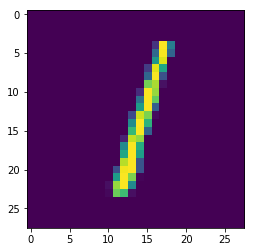

In [14]:
plt.imshow(x_test[2].reshape(28,28))
# generator.predict()

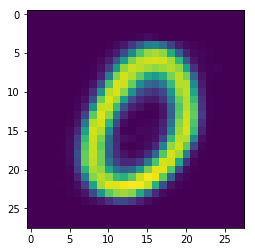

In [15]:
x_test_encoded[2]
dec_test = generator.predict(x_test_encoded[:5])
plt.imshow(dec_test[3].reshape(28,28))

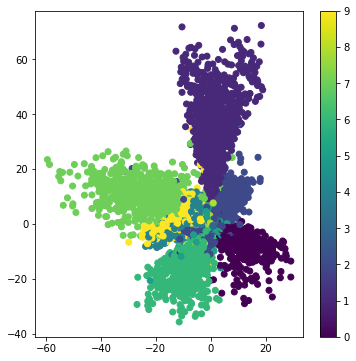

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [17]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 209,250
Trainable params: 209,250
Non-trainable params: 0
_________________________________________________________________


In [18]:
from datetime import date
print(date.today())
save_dir = '/home/elijahc/projects/vae/models/'+str(date.today())+'/'


2018-04-10


In [19]:
vae.save(save_dir+'vae_3layer.h5',include_optimizer=False)
encoder.save(save_dir+'enc.h5',include_optimizer=False)

OSError: Unable to create file (unable to open file: name = '/home/elijahc/projects/vae/models/2018-04-10/vae_3layer.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
x0 = np.array([0,-5])
x1 = np.array([0,5])
traj = gen_trajectory(x0,x1,delta=.1)
# traj[:3].shape
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,28,28)
dec_traj.shape

In [ ]:
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])